# Deep Collocation Method (DCM)

## ODE

$\frac{dy}{dx} = y, \quad y(0)=1$

Epoch 0, Loss: 1.364428
Epoch 500, Loss: 0.160394
Epoch 1000, Loss: 0.001593
Epoch 1500, Loss: 0.000540
Epoch 2000, Loss: 0.000198
Epoch 2500, Loss: 0.000106
Epoch 3000, Loss: 0.000056
Epoch 3500, Loss: 0.000035
Epoch 4000, Loss: 0.000023
Epoch 4500, Loss: 0.000017
MAE = 0.0012559426249936223


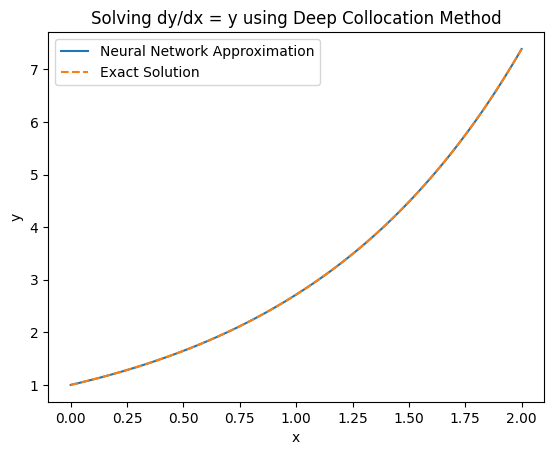

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

class CollocationNet(nn.Module):
    def __init__(self):
        super(CollocationNet, self).__init__()
        self.hidden = nn.Linear(1, 10) 
        self.output = nn.Linear(10, 1)
        self.activation = torch.tanh 

    def forward(self, x):
        x = self.activation(self.hidden(x))
        return self.output(x)

def loss_function(model, x_collocation, x_initial):
    x_collocation.requires_grad = True
    y_pred = model(x_collocation)

    dy_dx = torch.autograd.grad(y_pred, x_collocation, 
                                torch.ones_like(y_pred), create_graph=True)[0]

    collocation_loss = torch.mean((dy_dx - y_pred) ** 2)

    y_initial_pred = model(x_initial)
    initial_loss = (y_initial_pred - 1) ** 2

    return collocation_loss + initial_loss

x_collocation = torch.linspace(0, 2, 50).reshape(-1, 1)  
x_initial = torch.tensor([[0.0]]) 

model = CollocationNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_collocation, x_initial)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

x_test = torch.linspace(0, 2, 100).reshape(-1, 1)
y_pred = model(x_test).detach().numpy()
y_true = np.exp(x_test.numpy())  # حل دقیق y = e^x

print(f"MAE = {np.mean(np.abs(y_pred - y_true))}")
plt.plot(x_test.numpy(), y_pred, label="Neural Network Approximation")
plt.plot(x_test.numpy(), y_true, label="Exact Solution", linestyle="dashed")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.title("Solving dy/dx = y using Deep Collocation Method")
plt.show()

## PDE

### Heat equation

$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}, \quad x \in [0, L], \quad t > 0.$

Initial and boundary conditions:
- Initial: \( $u(x, 0) = f(x)$ \).
- Dirichlet boundary conditions: \( $u(0, t) = u(L, t) = 0$ \).

With considaration $f(x) = \sin(\pi x), L=1, $

The exact solution is:

$u(x,t) = e^{-\alpha \pi^2 t} \sin(\pi x).$

Epoch 0, Loss: 0.302597
Epoch 500, Loss: 0.000827
Epoch 1000, Loss: 0.000325
Epoch 1500, Loss: 0.000206
Epoch 2000, Loss: 0.000153
Epoch 2500, Loss: 0.000116
Epoch 3000, Loss: 0.000121
Epoch 3500, Loss: 0.000068
Epoch 4000, Loss: 0.000054
Epoch 4500, Loss: 0.000053
MAE = 0.0005511702297608935


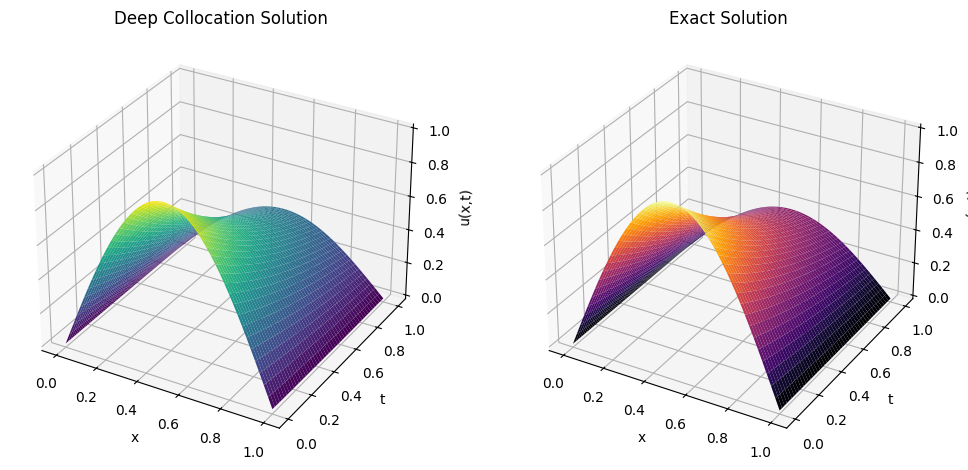

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)

alpha = 0.1  


class HeatEquationNN(nn.Module):
    def __init__(self):
        super(HeatEquationNN, self).__init__()
        self.hidden = nn.Linear(2, 20)  
        self.output = nn.Linear(20, 1)
        self.activation = torch.tanh  

    def forward(self, x, t):
        inputs = torch.cat((x, t), dim=1)  
        hidden_output = self.activation(self.hidden(inputs))
        return self.output(hidden_output)

def exact_solution(x, t):
    return np.exp(-alpha * np.pi**2 * t) * np.sin(np.pi * x)

def loss_function(model, x_collocation, t_collocation, x_boundary, t_boundary, x_initial, t_initial):
    x_collocation.requires_grad = True
    t_collocation.requires_grad = True

    u_pred = model(x_collocation, t_collocation)

    du_dt = torch.autograd.grad(u_pred, t_collocation, 
                                torch.ones_like(u_pred), create_graph=True)[0]
    du_dx = torch.autograd.grad(u_pred, x_collocation, 
                                torch.ones_like(u_pred), create_graph=True)[0]
    d2u_dx2 = torch.autograd.grad(du_dx, x_collocation, 
                                  torch.ones_like(du_dx), create_graph=True)[0]

    heat_eq_loss = torch.mean((du_dt - alpha * d2u_dx2) ** 2)

    u_boundary_pred = model(x_boundary, t_boundary)
    boundary_loss = torch.mean(u_boundary_pred ** 2)

    u_initial_pred = model(x_initial, t_initial)
    initial_loss = torch.mean((u_initial_pred - torch.sin(np.pi * x_initial)) ** 2)

    return heat_eq_loss + boundary_loss + initial_loss

num_collocation = 1000
x_collocation = torch.rand(num_collocation, 1) 
t_collocation = torch.rand(num_collocation, 1)  

x_boundary = torch.cat([torch.zeros(num_collocation // 2, 1), torch.ones(num_collocation // 2, 1)])
t_boundary = torch.rand(num_collocation, 1)  
x_initial = torch.rand(num_collocation, 1)  
t_initial = torch.zeros(num_collocation, 1) 

model = HeatEquationNN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 5000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_function(model, x_collocation, t_collocation, x_boundary, t_boundary, x_initial, t_initial)
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

X, T = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
X_flat = torch.tensor(X.flatten()).reshape(-1, 1).float()
T_flat = torch.tensor(T.flatten()).reshape(-1, 1).float()

U_pred = model(X_flat, T_flat).detach().numpy().reshape(50, 50)
U_exact = exact_solution(X, T)

print(f"MAE = {np.mean(np.abs(U_pred - U_exact))}")

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(X, T, U_pred, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u(x,t)")
ax.set_title("Deep Collocation Solution")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, T, U_exact, cmap="inferno")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u(x,t)")
ax2.set_title("Exact Solution")

plt.show()
